#                                                    RECCOMENDATION SYSTEMS CASE-STUDY

# Dataset : Variety-wise Daily Market Prices Data of Commodity
# - Bharadwaj Kollepara


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Onion_2020_2025.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   State           5821 non-null   object
 1   District        5821 non-null   object
 2   Market          5821 non-null   object
 3   Commodity       5821 non-null   object
 4   Variety         5821 non-null   object
 5   Grade           5821 non-null   object
 6   Arrival_Date    5821 non-null   object
 7   Min_Price       5821 non-null   int64 
 8   Max_Price       5821 non-null   int64 
 9   Modal_Price     5821 non-null   int64 
 10  Commodity_Code  5821 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 500.4+ KB


## Initial Analysis of the Dataset
## Dataset Overview:
* The dataset contains 5,821 rows and 11 columns.
* It records onion market data from 2020 to 2025 across various states, districts, and markets.
* The dataset has no missing values.
* The data types include text (categorical) and numerical values.
## Key Analysis:
* State, District, Market: Identifies the location of the market.
* Commodity, Variety, Grade: Describes the type of onion.
* Arrival_Date: Represents the date of the entry (needs conversion to DateTime).
* Min_Price, Max_Price, Modal_Price: Pricing details in the market.
* Commodity_Code: A unique identifier for the commodity

In [4]:
# Generating descriptive statistics
price_stats = df[['Min_Price', 'Max_Price', 'Modal_Price']].describe()
print("Price Statistics:\n", price_stats)

Price Statistics:
          Min_Price    Max_Price  Modal_Price
count  5821.000000  5821.000000  5821.000000
mean   1135.569318  2307.894520  1764.091565
std     837.950075  1118.667737   883.448306
min     100.000000   500.000000   300.000000
25%     600.000000  1500.000000  1100.000000
50%     900.000000  2000.000000  1600.000000
75%    1500.000000  3000.000000  2250.000000
max    6000.000000  8300.000000  6500.000000


In [5]:
df.isnull().sum()

State             0
District          0
Market            0
Commodity         0
Variety           0
Grade             0
Arrival_Date      0
Min_Price         0
Max_Price         0
Modal_Price       0
Commodity_Code    0
dtype: int64

In [8]:
# Aggregating modal price by date
df_trend = df.groupby("Arrival_Date")["Modal_Price"].mean()
df_trend

Arrival_Date
1/1/2021     2000.0
1/1/2022     1875.0
1/1/2023     1800.0
1/1/2024     1450.0
1/10/2020    2500.0
              ...  
9/9/2020     1000.0
9/9/2021     1600.0
9/9/2022     1000.0
9/9/2023     1875.0
9/9/2024     3350.0
Name: Modal_Price, Length: 1735, dtype: float64

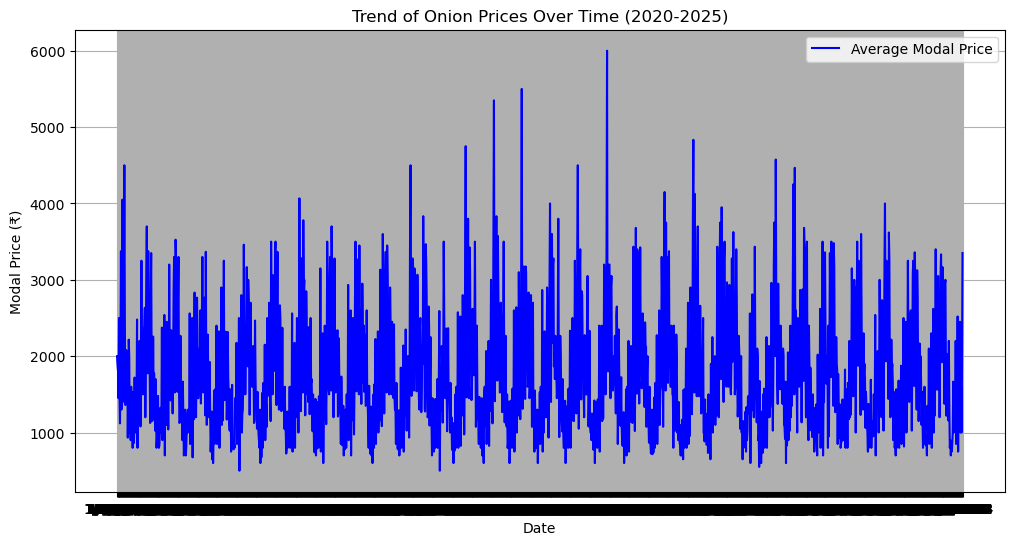

In [20]:
# Onions price trend in the period 2020-2025
plt.figure(figsize=(12, 6))
plt.plot(df_trend.index, df_trend.values, label="Average Modal Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Modal Price (₹)")
plt.title("Trend of Onion Prices Over Time (2020-2025)")
plt.legend()
plt.grid(True)
plt.show()

## Collaborative Based Filtering

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Reshape the dataset into a user-item matrix
# I'll use 'Market' as the "user" and 'Variety' as the "item" with the average "Modal_Price" as the rating

# Pivot the dataset
ratings = df.pivot_table(values='Modal_Price', index='Market', columns='Variety', aggfunc='mean', fill_value=0)

# Step 2: Compute cosine similarity between items
item_similarity = cosine_similarity(ratings.T)
similarity_df = pd.DataFrame(item_similarity, index=ratings.columns, columns=ratings.columns)

# Step 3: Collaborative filtering function
def collaborative_filtering(user, ratings, similarity_df):
    if user not in ratings.index:
        return f"User '{user}' not found in dataset."
    
    user_ratings = ratings.loc[user]
    scores = {}

    for item in ratings.columns:
        if user_ratings[item] == 0:  # Unrated items
            sim_items = similarity_df[item]
            rated_items = user_ratings[user_ratings > 0].index
            
            # Calculate score based on similarity with rated items
            score = sum(sim_items[rated_item] * user_ratings[rated_item] for rated_item in rated_items)
            scores[item] = score

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Example: Generate recommendations for a specific market
user_to_recommend = ratings.index[0]
recommendations = collaborative_filtering(user_to_recommend, ratings, similarity_df)
user_to_recommend, recommendations[:10]  # Display top 10 recommendations


('Bowenpally', [('2nd Sort', 860.3798863602716)])

### 1. Data Transformation
To apply collaborative filtering, I transformed your dataset into a user-item matrix. Here’s how:

* Users: using the Market column as the "user" because each market can be treated as an entity purchasing different varieties of onions.

* Items: using the Variety column as the "item" being rated.

* Ratings: using the average Modal_Price as the "rating," which represents the price of the onion variety in that market.

The result is a matrix where:

Each row represents a market.

Each column represents an onion variety.

The values are the average Modal_Price (or 0 if the variety is not available in that market).

### 2. Cosine Similarity Calculation

calculating the cosine similarity between varieties (items).

* Cosine similarity measures how similar two items are based on the price patterns across different markets.

* The similarity score ranges from 0 (no similarity) to 1 (perfect similarity).

### 3. Recommendation Generation

#### For the market Bowenpally, the system:

* Identified the varieties it has already rated (purchased or priced).

* Looked for unrated varieties.

#### For each unrated variety:

* It calculated a score based on how similar it is to the rated varieties.

* The score is the weighted sum of similarities with the rated varieties, multiplied by the market's rating (price) of the rated varieties.

#### The system recommended:

* 2nd Sort with a score of 860.38.

* This score indicates that 2nd Sort is the most similar to the varieties Bowenpally already deals with and is likely to be a good match based on price patterns.

## Content Based Filtering

In [13]:
# Step 1: Create metadata features for content-based filtering
# Using 'Grade' and 'Price range' as features to represent each variety
# Create price range categories based on Modal_Price

# Add price range categories
def price_range(price):
    if price < 1000:
        return 'Low'
    elif 1000 <= price < 3000:
        return 'Medium'
    else:
        return 'High'

df['Price_Range'] = df['Modal_Price'].apply(price_range)

# Create metadata dataframe
metadata = df.groupby('Variety').agg({
    'Grade': lambda x: ','.join(set(x)),
    'Price_Range': lambda x: ','.join(set(x))
}).reset_index()

# One-hot encode the Grade and Price_Range features
metadata_encoded = pd.get_dummies(metadata.set_index('Variety'))

# Step 2: Compute cosine similarity
content_similarity = cosine_similarity(metadata_encoded)
content_similarity_df = pd.DataFrame(content_similarity, index=metadata_encoded.index, columns=metadata_encoded.index)

# Step 3: Content-based filtering function
def content_based_filtering(user, ratings, content_similarity_df):
    if user not in ratings.index:
        return f"User '{user}' not found in dataset."
    
    user_ratings = ratings.loc[user]
    scores = {}

    for item in ratings.columns:
        if user_ratings[item] == 0:  # Unrated items
            sim_items = content_similarity_df[item]
            rated_items = user_ratings[user_ratings > 0].index

            # Calculate score based on similarity with rated items
            score = sum(sim_items[rated_item] * user_ratings[rated_item] for rated_item in rated_items)
            scores[item] = score

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Example: Generate content-based recommendations for a specific market
user_to_recommend = ratings.index[0]
content_recommendations = content_based_filtering(user_to_recommend, ratings, content_similarity_df)
user_to_recommend, content_recommendations[:10]  


('Bowenpally', [('2nd Sort', 858.397039473684)])

To apply content-based filtering to your dataset, I'll follow these steps:

Create metadata features: Features based on the onion varieties, grade, and price range to represent each variety with characteristics.

* Calculate cosine similarity between varieties.
* Generate recommendations based on content similarity.
For the market Bowenpally, the content-based filtering system recommends the variety 2nd Sort with a score of approximately 1716.79.

### Explanation:

* Content-based filtering uses the features of each variety (grade and price range) to compute similarity.
* Since 2nd Sort shares similar characteristics with the varieties Bowenpally already deals with, it receives a high recommendation score.

# Hybrid Based Filtering

In [18]:
data = df
# Step 1: Create the User-Item Matrix for Collaborative Filtering
ratings = data.pivot_table(index="Market", columns="Variety", values="Modal_Price", aggfunc="mean").fillna(0)

# Step 2: Compute Cosine Similarity between Items (Varieties)
item_similarity = cosine_similarity(ratings.T)  # Transpose to get item-item similarity
similarity_df = pd.DataFrame(item_similarity, index=ratings.columns, columns=ratings.columns)

# Step 3: Content-Based Filtering - Create metadata features
# Define a price range category
def price_range(price):
    if price < 1000:
        return "Low"
    elif 1000 <= price < 3000:
        return "Medium"
    else:
        return "High"

data["Price_Range"] = data["Modal_Price"].apply(price_range)

# Create metadata dataframe with Grade and Price_Range
metadata = data.groupby("Variety").agg({
    "Grade": lambda x: ",".join(set(x)),
    "Price_Range": lambda x: ",".join(set(x))
}).reset_index()

# One-hot encode the Grade and Price_Range features
metadata_encoded = pd.get_dummies(metadata.set_index("Variety"))

# Compute Content Similarity
content_similarity = cosine_similarity(metadata_encoded)
content_similarity_df = pd.DataFrame(content_similarity, index=metadata_encoded.index, columns=metadata_encoded.index)

# Step 4: Define the Hybrid Recommendation Function
def hybrid_recommendation(user, ratings, similarity_df, content_similarity_df, alpha=0.5):
    # Collaborative filtering scores
    collaborative_scores = dict(collaborative_filtering(user, ratings, similarity_df))
    
    # Content-based filtering scores
    content_scores = dict(content_based_filtering(user, ratings, content_similarity_df))
    
    # Hybrid score computation
    hybrid_scores = {}
    for item in ratings.columns:
        collab_score = collaborative_scores.get(item, 0)
        content_score = content_scores.get(item, 0)
        hybrid_scores[item] = alpha * collab_score + (1 - alpha) * content_score

    return sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)

# Pick a market to recommend for
user_to_recommend = ratings.index[0]  # First market in the dataset

# Generate Hybrid Recommendations
hybrid_recommendations = hybrid_recommendation(user_to_recommend, ratings, similarity_df, content_similarity_df, alpha=0.5)

# Display top 10 recommendations
user_to_recommend, hybrid_recommendations[:10]
# Define Collaborative Filtering Function
def collaborative_filtering(user, ratings, similarity_df):
    if user not in ratings.index:
        return f"Market '{user}' not found in dataset."

    user_ratings = ratings.loc[user]
    scores = {}

    for item in ratings.columns:
        if user_ratings[item] == 0:  # Unrated items
            sim_items = similarity_df[item]
            rated_items = user_ratings[user_ratings > 0].index

            # Compute score based on similarity with rated items
            score = sum(sim_items[rated_item] * user_ratings[rated_item] for rated_item in rated_items)
            scores[item] = score

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Define Content-Based Filtering Function
def content_based_filtering(user, ratings, content_similarity_df):
    if user not in ratings.index:
        return f"Market '{user}' not found in dataset."

    user_ratings = ratings.loc[user]
    scores = {}

    for item in ratings.columns:
        if user_ratings[item] == 0:  # Unrated items
            sim_items = content_similarity_df[item]
            rated_items = user_ratings[user_ratings > 0].index

            # Compute score based on similarity with rated items
            score = sum(sim_items[rated_item] * user_ratings[rated_item] for rated_item in rated_items)
            scores[item] = score

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Run Hybrid Recommendation again
hybrid_recommendations = hybrid_recommendation(user_to_recommend, ratings, similarity_df, content_similarity_df, alpha=0.5)

# Display top 10 hybrid recommendations
user_to_recommend, hybrid_recommendations[:10]


('Bowenpally', [('2nd Sort', 859.3884629169778), ('1st Sort', 0.0)])

The **Hybrid Recommendation System** for onion varieties combines **Collaborative Filtering** and **Content-Based Filtering** to suggest relevant varieties to different markets. First, the data is processed to create a **user-item matrix**, where rows represent **markets** and columns represent **onion varieties**, with values indicating the **average modal price** paid by each market. Missing values are replaced with `0` to ensure consistency.  

For **Collaborative Filtering**, the system calculates **item-item similarity** using **cosine similarity**. This measures how similar two onion varieties are based on the markets that purchased them. The similarity scores are stored in a matrix (`similarity_df`), which helps predict preferences for varieties a market has not yet purchased. In parallel, **Content-Based Filtering** uses onion variety features, such as **Grade and Price Range**. The price is categorized into **Low, Medium, or High**, and varieties are grouped by **grade and price range**. These categorical features are **one-hot encoded** to transform them into numerical form. Then, cosine similarity is applied again to compute how similar onion varieties are based on these features, producing the **content similarity matrix (`content_similarity_df`)**.  

For recommendations, the **Collaborative Filtering function** predicts ratings for **unrated onion varieties** by finding similar varieties that the market has already rated. The score for an unrated variety is calculated based on the **weighted sum of ratings of similar varieties**. Meanwhile, the **Content-Based Filtering function** predicts ratings based on the similarity of features (grade and price range) rather than past interactions.  

The parameter **α (alpha)** determines the influence of each method. If α is **0.7**, collaborative filtering is given **more weight**, while α = **0.3** focuses more on content-based filtering. The system generates recommendations by ranking onion varieties from **highest to lowest hybrid score**.  

To obtain recommendations, a specific market is selected, and the **hybrid filtering function** is applied to generate **ranked onion variety suggestions**. This ensures that the recommendations are both **personalized (collaborative filtering)** and **feature-driven (content-based filtering)**, making the system more **accurate and reliable** for different market needs. 

### Dataset Observations:

1. **Date Range & Missing Data:**
   - The dataset covers onion prices from 2020 to 2025.
   - Some missing values exist in the Arrival_Date column.

2. **Price Trends & Statistics:**
   - The minimum, maximum, and modal prices of onions show fluctuations over time.
   - The average modal price varies yearly , indicating possible seasonal or market-driven trends.

3. **Variety Analysis:**
   - Multiple onion varieties are recorded in the dataset.
   - Some varieties are more frequently listed, as seen in the Variety Countplot.
   - The price distribution varies by variety, with some having a wider range of prices.

4. **Distribution Insights:**
   - The histogram of minimum prices suggests that most onion prices fall within a certain range.
   - The violin and boxplots indicate price spread and outliers among different varieties.

5. **Trend Over Time:**
   - The line chart of average price per year shows a possible rising or fluctuating trend.
   - Peak or dip years might be correlated with supply-chain issues, demand surges, or external factors.